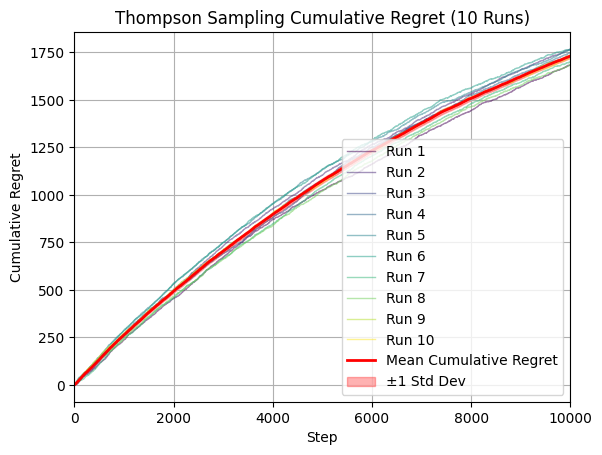

✅ Total execution time: 15.25 seconds


In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

start_time = time.time()

# Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# Thompson Sampling strategy
def thompson_sampling(K, n, reward_lists, B):
    np.random.seed(int(time.time()))
    random.seed(time.time())
    
    rewards, choices, regrets = [], [], []  # To record the reward, chosen arm, and regret at each step
    empirical_means = np.zeros(K)  # To record the empirical mean reward for each arm
    action_counts = np.zeros(K)  # To record the number of times each arm has been chosen
    cumulative_regrets = np.zeros(n)  # To record the cumulative regret at each step
    
    # Initialize prior parameters for each arm (assuming rewards follow a normal distribution)
    prior_means = np.zeros(K)  # Prior means
    prior_variances = np.ones(K) * (B**2 / 4)  # Prior variances

    # TS algorithm
    for t in range(1, n + 1):
        # Sample from the posterior distribution of each arm
        sample_means = np.random.normal(prior_means, np.sqrt(prior_variances))
        arm = np.argmax(sample_means)  # Choose the arm with the highest sample mean
        r = random.choice(reward_lists[arm])  # Randomly select a reward from the chosen arm's reward list
        
        rewards.append(r)  # Record the reward for this step
        choices.append(arm)  # Record the chosen arm for this step
        action_counts[arm] += 1  # Update the count of the chosen arm
        empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]  # Update the empirical mean reward
        
        # Update the posterior distribution parameters
        prior_means[arm] = (prior_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]
        prior_variances[arm] = (B**2 / 4) / action_counts[arm]
        
        # Calculate the regret for this step
        best_arm_mean = np.max(empirical_means)  # Find the arm with the highest empirical mean reward
        regrets.append(best_arm_mean - r)  # Calculate the regret for this step
        cumulative_regrets[t - 1] = np.sum(regrets)  # Calculate the cumulative regret
    
    return cumulative_regrets

# Load preprocessed data
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())  # Use preprocessed rewards
K = len(arms)  # Number of arms (genres)

# Calculate B: the difference between the maximum and minimum movie ratings
B = 5  # Assuming the ratings are normalized to [0, 1]

# Example parameters
n = 10000  # Total number of time steps

# Run TS ten times
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

# Use different colors for each run
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

for i in range(num_runs):
    cumulative_regrets = thompson_sampling(K, n, reward_lists, B)
    all_cumulative_regrets[i, :] = cumulative_regrets
    plt.plot(cumulative_regrets, color=colors[i], alpha=0.5, linewidth=1, label=f'Run {i + 1}')

# Calculate the average cumulative regret and standard deviation
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = std_cumulative_regrets / np.sqrt(num_runs)

# Plot the average cumulative regret and error bars
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n), 
                 mean_cumulative_regrets - stderr_cumulative_regrets, 
                 mean_cumulative_regrets + stderr_cumulative_regrets, 
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('Thompson Sampling Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")

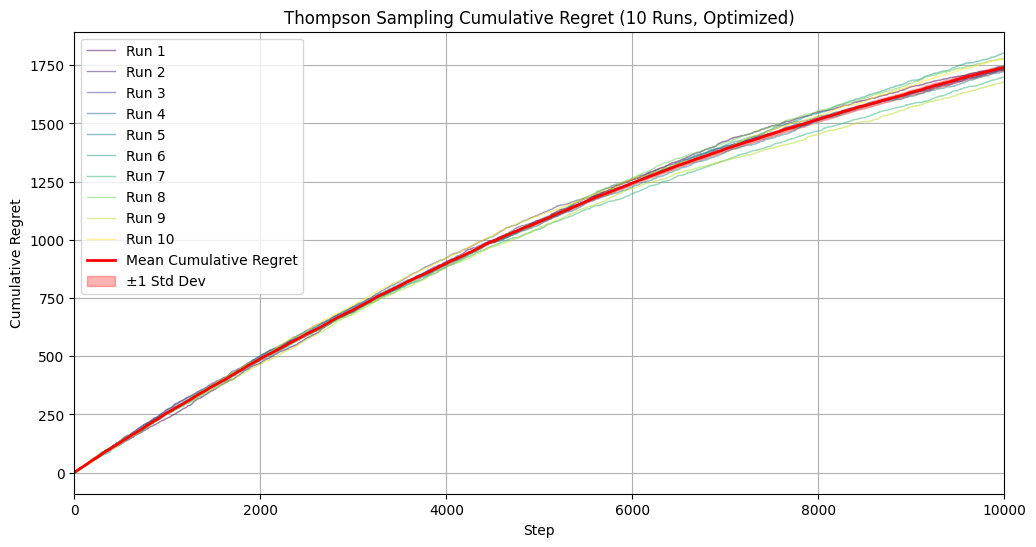

✅ Total execution time: 0.34 seconds


In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
from joblib import Parallel, delayed  # ✅ Optimization: Enables parallelism

# ✅ Load preprocessed data (no changes needed)
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# ✅ Optimized Thompson Sampling with all enhancements
def thompson_sampling(K, n, reward_lists, B, seed_offset=0):
    # ✅ Optimization 1: Fixed seed for reproducibility
    np.random.seed(42 + seed_offset)
    random.seed(42 + seed_offset)

    action_counts = np.zeros(K)
    empirical_means = np.zeros(K)
    cumulative_regrets = np.zeros(n)

    # Prior for normal reward distribution
    prior_means = np.zeros(K)
    prior_variances = np.ones(K) * (B**2 / 4)

    # ✅ Optimization 2: Use true mean to compute regret (no need to estimate again)
    true_means = np.array([np.mean(r) for r in reward_lists])
    best_mean = np.max(true_means)

    for t in range(n):
        # Thompson Sampling: sample each arm
        sample_means = np.random.normal(prior_means, np.sqrt(prior_variances))
        arm = np.argmax(sample_means)
        reward = random.choice(reward_lists[arm])

        # ✅ Optimization 3: Use Welford update (numerically stable)
        action_counts[arm] += 1
        empirical_means[arm] += (reward - empirical_means[arm]) / action_counts[arm]

        # ✅ Optimization 4: Direct posterior update using Welford mean
        prior_means[arm] = empirical_means[arm]
        prior_variances[arm] = (B**2 / 4) / action_counts[arm]

        # ✅ Optimization 5: Cumulative regret with incremental update
        regret = best_mean - reward
        cumulative_regrets[t] = regret if t == 0 else cumulative_regrets[t - 1] + regret

        # Old (less stable/efficient) method:
        # empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + reward) / action_counts[arm]
        # prior_means[arm] = (prior_means[arm] * (action_counts[arm] - 1) + reward) / action_counts[arm]
        # regrets.append(best_mean - reward)
        # cumulative_regrets[t] = np.sum(regrets)

    return cumulative_regrets

# ✅ Load data
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
n = 10000
B = 5
num_runs = 10

# ✅ Optimization 6: Record full script runtime
start_time = time.time()

# ✅ Optimization 7: Parallel runs
all_cumulative_regrets = Parallel(n_jobs=-1)(
    delayed(thompson_sampling)(K, n, reward_lists, B, seed_offset=i)
    for i in range(num_runs)
)
all_cumulative_regrets = np.array(all_cumulative_regrets)

# ✅ Aggregation & Visualization
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = np.std(all_cumulative_regrets, axis=0) / np.sqrt(num_runs)

colors = plt.cm.viridis(np.linspace(0, 1, num_runs))
plt.figure(figsize=(12, 6))
for i in range(num_runs):
    plt.plot(all_cumulative_regrets[i], color=colors[i], alpha=0.5, linewidth=1, label=f'Run {i + 1}')
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n),
                 mean_cumulative_regrets - stderr_cumulative_regrets,
                 mean_cumulative_regrets + stderr_cumulative_regrets,
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('Thompson Sampling Cumulative Regret (10 Runs, Optimized)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")
